In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
from hits.visualize import interactive
from bokeh.io import output_notebook
from hdbscan import HDBSCAN

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Loading BokehJS ...

# Parameters

In [2]:
PREFIX = '20240125_RPE1_E150_essentials_max_ol_'
EXPERIMENT = '/data/norman/southark/rpe1e150_standardized/'

In [3]:
#load pop with all singlets and multiplets
full_pop = sc.read_h5ad('/data/norman/southark/rpe1e150_standardized/240129_rpe1_e150_maxol_crispri_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_cellranger_guide_calls.h5ad')

In [4]:
full_pop = CellPopulation(pd.DataFrame(full_pop.X.todense().A, index=full_pop.obs.index, columns=full_pop.var.index), full_pop.obs, full_pop.var, calculate_statistics=False)

Done.


In [5]:
full_pop.cells = full_pop.cells.rename(columns={'UMI_count_x': 'UMI_count', 'UMI_count_y': 'guide_UMI_count'})

In [6]:
full_pop.cells['guide_target'] = full_pop.cells['guide_identity'].map(lambda x: x.split('_')[1] if 'non' not in x else 'non-targeting')
full_pop.cells['perturbed'] = full_pop.cells['guide_target']
full_pop.cells['single_cell'] = True

In [7]:
full_pop.cells['guide_identity'] = full_pop.cells['guide_identity'].astype(str)
full_pop.cells['gem_group'] = full_pop.cells['gem_group'].astype(int)
full_pop.cells['num_umis'] = full_pop.cells['num_umis'].astype(str)
full_pop.cells['feature_call'] = full_pop.cells['feature_call'].astype(str)
full_pop.cells['number_of_cells'] = full_pop.cells['number_of_cells'].astype(int)

# Droplet quality filtering

Text(0, 0.5, 'Median UMI count')

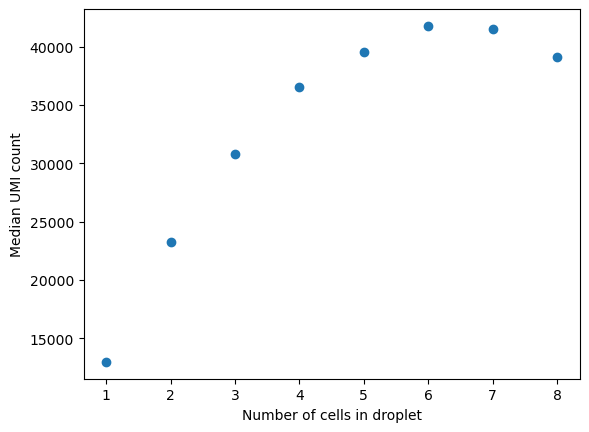

In [8]:
df = full_pop.cells.query('gem_group==1 and number_of_cells <= 8')[['UMI_count', 'number_of_cells']].groupby('number_of_cells').median()

plt.scatter(df.index, df['UMI_count'])
plt.xlabel('Number of cells in droplet')
plt.ylabel('Median UMI count')

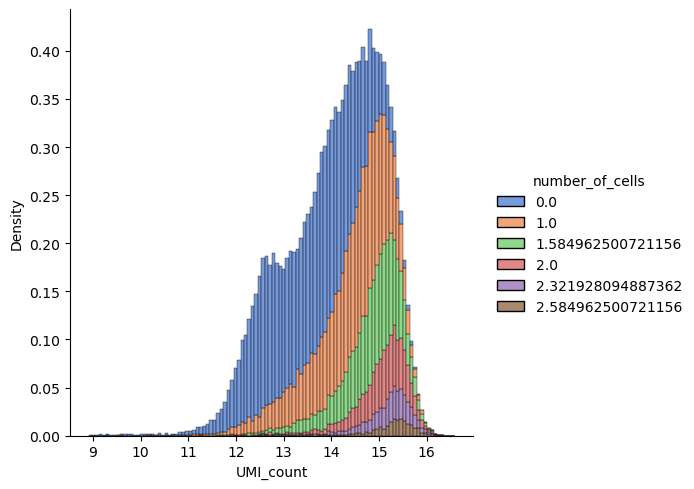

In [9]:
sns.displot(data=np.log2(full_pop.cells.query('number_of_cells <= 6')[['UMI_count', 'number_of_cells']]), x='UMI_count', hue='number_of_cells', palette='muted', stat='density', multiple='stack')

In [10]:
UMI_thresholds = {1: 2**10.7, 2: 2**11, 3: 2**12, 4: 2**12.7, 5: 2**13.5, 6:2**14}

(0.0, 80000.0)

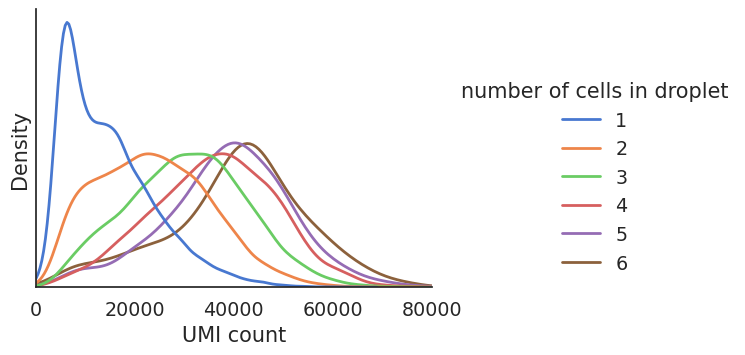

In [11]:
df = full_pop.cells.query('gem_group==1 and number_of_cells <= 6')[['UMI_count', 'number_of_cells']]
df.columns = ['UMI count', 'number of cells in droplet']

sns.set(font_scale=1.25)
sns.set_style('white')
sns.displot(data=df,
            x='UMI count', hue='number of cells in droplet', palette='muted', kind='kde', common_norm=False,
           height=4, aspect=1.25, linewidth=2)
plt.yticks([])
plt.xlim([0, 80000])

In [12]:
mt_genes = full_pop.genes[full_pop.genes['gene_name'].str.startswith('MT-')].query('mean > 1').index
full_pop.cells['mt_frac'] = full_pop.matrix[mt_genes].sum(axis=1)/full_pop.cells['UMI_count']

(0.0, 80000.0)

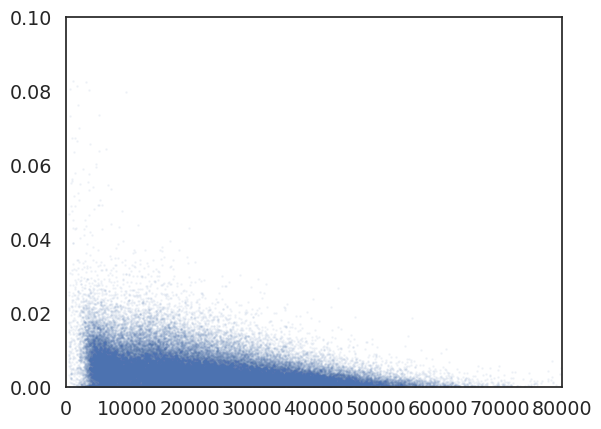

In [13]:
plt.scatter(full_pop.cells['UMI_count'], full_pop.cells['mt_frac'], s=1, alpha=0.05)
plt.ylim([0, 0.1])
plt.xlim([0, 80000])

In [14]:
full_pop.cells['keep'] = (full_pop.cells['UMI_count'] > full_pop.cells['number_of_cells'].map(UMI_thresholds)) \
                          & (full_pop.cells['mt_frac'] < 0.03)

In [15]:
full_pop.cells.query('keep').groupby(['gem_group', 'number_of_cells'])['number_of_cells'].sum()

gem_group  number_of_cells
1          1                  16911
           2                  19416
           3                  15114
           4                   9156
           5                   5275
           6                   2706
2          1                  16770
           2                  19608
           3                  15702
           4                  10260
           5                   5910
           6                   3354
Name: number_of_cells, dtype: int64

In [16]:
full_pop.genes['in_matrix'] = True

In [17]:
full_pop = full_pop.subpopulation(cells='keep')

Generating summary statistics...
Done.


In [18]:
strip_low_expression(full_pop, threshold=0)

In [19]:
full_pop.genes['in_matrix'] = full_pop.genes['mean'] > 0

# Filtering of control guides for possible on-target effects

In [20]:
expr = full_pop.where('guide_target=="non-targeting" and number_of_cells==1', genes='mean > 1')
expr['guide_identity'] = full_pop.cells['guide_identity']
expr.set_index('guide_identity', append=True, inplace=True)
expr = (expr - expr.mean()).div(expr.std())

In [21]:
mean_expr = expr.groupby(level=1).mean()

In [22]:
expr.groupby(level=1).size().sort_values()

guide_identity
non-targeting_gfp       11
non-targeting_01537     81
non-targeting_00843     95
non-targeting_02717     96
non-targeting_01377     99
non-targeting_03602    102
non-targeting_01195    131
non-targeting_00236    140
non-targeting_02833    145
non-targeting_02622    147
non-targeting_01615    159
non-targeting_03504    171
non-targeting_03760    176
non-targeting_02274    182
non-targeting_02969    194
non-targeting_02049    242
non-targeting_00532    937
dtype: int64

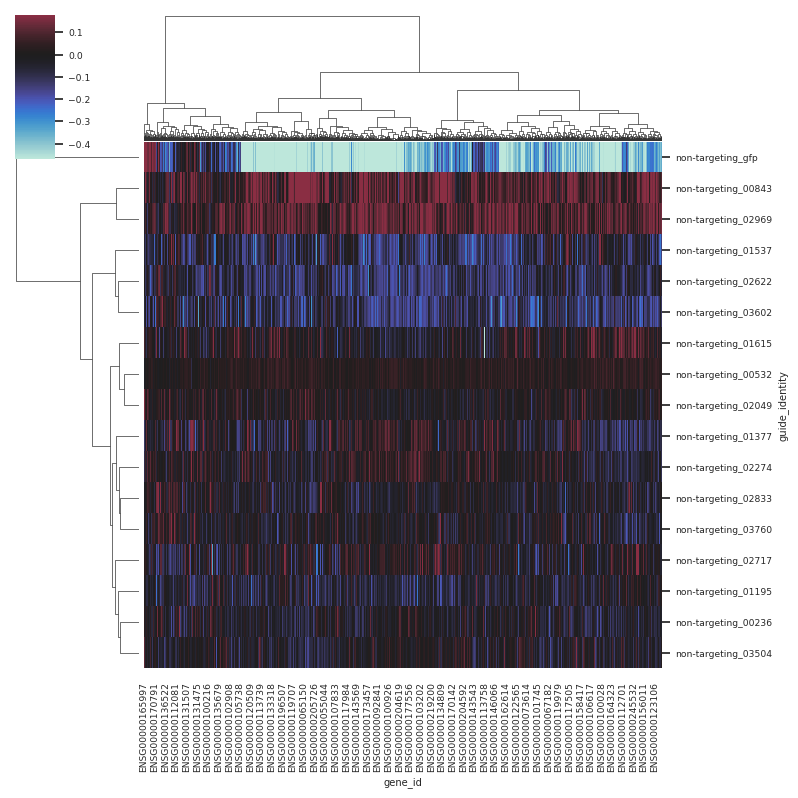

In [23]:
sns.set(font_scale=0.6)
sns.clustermap(mean_expr, method='ward', robust=True, center=0, figsize=[8,8])

In [24]:
mean_expr.abs().sum(axis=1).sort_values()

guide_identity
non-targeting_00532     113.383125
non-targeting_02049     134.054779
non-targeting_03504     162.620422
non-targeting_02274     169.303589
non-targeting_03760     173.833832
non-targeting_02833     173.905869
non-targeting_00236     183.370224
non-targeting_01615     188.860687
non-targeting_02717     197.061737
non-targeting_01195     219.690704
non-targeting_01377     235.691986
non-targeting_01537     316.619415
non-targeting_02969     324.822388
non-targeting_02622     329.861908
non-targeting_00843     350.834106
non-targeting_03602     358.429718
non-targeting_gfp      1209.624634
dtype: float32

In [25]:
good_controls = np.setdiff1d(expr.index.get_level_values(1).unique(), ['non-targeting_gfp', 'non-targeting_01615'])

In [26]:
good_controls

array(['non-targeting_00236', 'non-targeting_00532',
       'non-targeting_00843', 'non-targeting_01195',
       'non-targeting_01377', 'non-targeting_01537',
       'non-targeting_02049', 'non-targeting_02274',
       'non-targeting_02622', 'non-targeting_02717',
       'non-targeting_02833', 'non-targeting_02969',
       'non-targeting_03504', 'non-targeting_03602',
       'non-targeting_03760'], dtype=object)

In [27]:
full_pop.cells.query('number_of_cells==1 and guide_identity in @good_controls').groupby('gem_group').size()

gem_group
1    1501
2    1437
dtype: int64

In [28]:
full_pop.cells['control'] = (full_pop.cells['number_of_cells'] == 1) & (full_pop.cells['guide_identity'].isin(good_controls))

# Identify stably captured genes

In [29]:
from itertools import combinations
from scipy.stats import wasserstein_distance
from itertools import combinations

In [30]:
def get_p(pop, genes=None, UMI_counts=None):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    ps = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
                    
        ps[gem] = p
    
    ps = pd.concat(ps.values())

    return ps

def get_stratified_expression(pop, stratify, cells=None, genes=None, normalized=False, normalized_name=None, **kwargs):
    expr = pop.where(cells=cells, genes=genes, normalized=normalized, normalized_name=normalized_name, **kwargs).copy()
    
    for key in stratify:
        expr[key] = pop.cells[key]
        
    expr.set_index(stratify, append=True, inplace=True)
    levels_order = expr.index.names
    new_order = levels_order[1:] + [levels_order[0]]
    expr = expr.reorder_levels(new_order)

    return expr

def pairwise_sum_wasserstein(p):
    number_of_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(number_of_cells, 2):
        dists.append(wasserstein_distance(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

In [31]:
full_pop.normalized_matrix = dict()

In [ ]:
full_pop.normalized_matrix['p'] = get_p(full_pop)

In [ ]:
p = get_stratified_expression(full_pop,
                              ['gem_group', 'number_of_cells'],
                              genes='mean > 0.5',
                              normalized=True, normalized_name='p')

In [ ]:
def process_gem_group(gem_group):
    local_dists = dict()
    gem_group_p = p.loc[gem_group]
    for gene, col in gem_group_p.iteritems():
        local_dists[(gem_group, gene)] = pairwise_sum_wasserstein(col)
    return local_dists

# Parallelize the outer loop
n_jobs = 10  # Use all available cores
gem_groups = p.index.get_level_values(0).unique()
results = Parallel(n_jobs=n_jobs)(delayed(process_gem_group)(gem_group) for gem_group in tqdm(gem_groups, total=len(gem_groups)))

# Merge the results from all workers into the main dict
dists = {k: v for res in results for k, v in res.items()}

In [ ]:
full_pop.genes['pairwise_p_cost'] = np.log10(pd.Series(dists).unstack().sum())

## Fitting adjusted total cost

In [ ]:
from sklearn.linear_model import HuberRegressor

regr = HuberRegressor()
X = np.log10(full_pop.genes.query('mean > 0.5')['mean']).values.reshape(-1, 1)
y = full_pop.genes.query('mean > 0.5')['pairwise_p_cost']

regr.fit(X, y)
pred_costs = pd.Series(regr.predict(X), index=y.index)
full_pop.genes['mean_adjusted_pairwise_p_cost'] = full_pop.genes['pairwise_p_cost'] - pred_costs

plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['pairwise_p_cost'], s=1)

plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           pred_costs, s=1)

In [ ]:
plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['mean_adjusted_pairwise_p_cost'], s=1)

## Fitting excess CV

In [ ]:
from scipy.signal import medfilt
from scipy.interpolate import interp1d

def calculate_excess_cv(pop, mean_threshold=0.05, exclude=[], resolution=1000):
    """Calculates the excess coefficient of variation (CV) for each gene.
    
    Args:
        pop: CellPopulation instance
        mean_threshold: only consider genes with mean expression level above this value
        exclude: list of gene names or gene ids to not include in the calculation
        resolution: number of bins to use when interpolating mean-CV relationship
        
    Returns:
        Series of excess CV for each gene.
    """
    if len(exclude) > 0:
        exclude = pop.gene_ids(exclude)
    
    thresholded_genes = pop.genes.query('mean > @mean_threshold').sort_values('mean', ascending=False)
    thresholded_genes = thresholded_genes.query('index not in @exclude')
    
    gene_means_mean_ordered = thresholded_genes['mean']
    gene_cvs_mean_ordered = thresholded_genes['cv']
    gene_cvs_mean_ordered_medfilt = pd.Series(medfilt(gene_cvs_mean_ordered, kernel_size=15), index=gene_cvs_mean_ordered.index)
    
    ind = np.arange(0, len(gene_means_mean_ordered), len(gene_means_mean_ordered)/resolution)
    cv_interpolater = interp1d(gene_means_mean_ordered.iloc[ind], gene_cvs_mean_ordered_medfilt.iloc[ind], fill_value="extrapolate")
    
    predicted_cv = pd.Series(cv_interpolater(gene_means_mean_ordered), index=gene_means_mean_ordered.index)
    excess_cv = gene_cvs_mean_ordered/predicted_cv
    thresholded_genes['excess_cv'] = excess_cv
    
    return thresholded_genes['excess_cv']

In [ ]:
full_pop.genes['excess_cv'] = calculate_excess_cv(full_pop, mean_threshold=1e-6)
sns.distplot(full_pop.genes['excess_cv'])

In [ ]:
sns.distplot(full_pop.genes['mean_adjusted_pairwise_p_cost'])

## Picking stably captured genes

In [ ]:
full_pop.genes['pairwise_chosen'] = full_pop.genes.index.isin(full_pop.genes.dropna(subset='mean_adjusted_pairwise_p_cost').query('excess_cv < 1 and mean_adjusted_pairwise_p_cost < {0:0.8f}'.format(full_pop.genes['mean_adjusted_pairwise_p_cost'].quantile(0.2))).index)

In [ ]:
full_pop.genes['pairwise_chosen'].sum()

# Fit scale coefficients to stable genes


In [ ]:
from sklearn.linear_model import HuberRegressor

def fit_robust_regression(x, y, name=None, fit_intercept=False):
    # Convert pandas series to numpy array as required by sklearn
    x_np = x.to_numpy().reshape(-1, 1)
    y_np = y.to_numpy()
    
    # Instantiate a HuberRegressor object with no intercept
    huber = HuberRegressor(fit_intercept=fit_intercept, max_iter=500)
    
    # Fit the Huber regression model to the data
    try:
        huber.fit(x_np, y_np)
        coef = huber.coef_[0]
        umi_pred = huber.predict(x_np).sum()
        raw_umi_pred = x_np.sum()
    except ValueError:
        coef = np.nan
        umi_pred = np.nan
        raw_umi_pred = np.nan
        
    if not fit_intercept:
        if name is None:
            return (coef, umi_pred, raw_umi_pred)
        else:
            return (name, coef, umi_pred, raw_umi_pred)
    else:
        if name is None:
            return (coef, huber.intercept_, umi_pred, raw_umi_pred)
        else:
            return (name, coef, huber.intercept_, umi_pred, raw_umi_pred)

def get_mean_coefs(pop, stable_genes, trim=None, fit_intercept=False):    
    all_coefs = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        for num in pop.cells['number_of_cells'].unique():
            target_cells = pop.cells[(pop.cells['gem_group']==gem) & (pop.cells['number_of_cells']==num)].index
            stable_expr = pop.where(cells=target_cells,
                                    genes=stable_genes)
            if trim is None:
                stable_mean_expr = stable_expr.mean()
            else:
                stable_mean_expr = stable_expr.apply(lambda x: trim_mean(x, trim))

            coefs = Parallel(n_jobs=16, verbose=10)(delayed(fit_robust_regression)(row, stable_mean_expr, name=cell_bc, fit_intercept=fit_intercept) for cell_bc, row in stable_expr.iterrows())

            if not fit_intercept:
                all_coefs[(gem, num)] = pd.DataFrame(coefs, columns=['cell_barcode', 'huber_coef', 'huber_UMI_count', 'raw_huber_UMI_count']).set_index('cell_barcode')
            else:
                all_coefs[(gem, num)] = pd.DataFrame(coefs,
                                              columns=['cell_barcode', 'huber_intercept_coef', 'huber_intercept', 'huber_intercept_UMI_count', 'raw_huber_intercept_UMI_count']).set_index('cell_barcode')
    
    return pd.concat(all_coefs.values())

In [ ]:
pairwise_mean_coefs = get_mean_coefs(full_pop, full_pop.genes.query('pairwise_chosen').index)

In [ ]:
pairwise_mean_coefs['UMI_count'] = full_pop.cells['UMI_count']
pairwise_mean_coefs['number_of_cells'] = full_pop.cells['number_of_cells']
pairwise_mean_coefs['pred_UMI_count'] = pairwise_mean_coefs['UMI_count']*pairwise_mean_coefs['huber_coef']
pairwise_mean_coefs['gem_group'] = full_pop.cells['gem_group']

In [ ]:
sns.set_style('white')
sns.pairplot(pairwise_mean_coefs.query('gem_group==1').drop('gem_group', axis=1), hue='number_of_cells')

In [48]:
full_pop.cells['pairwise_coef'] = pairwise_mean_coefs['huber_coef']
full_pop.cells['pairwise_UMI_count'] = pairwise_mean_coefs['pred_UMI_count']
full_pop.cells['pairwise_singlet_equivalent_UMI_count'] = full_pop.cells['pairwise_UMI_count']/full_pop.cells.groupby(['gem_group', 'number_of_cells'])['pairwise_UMI_count'].transform('median')

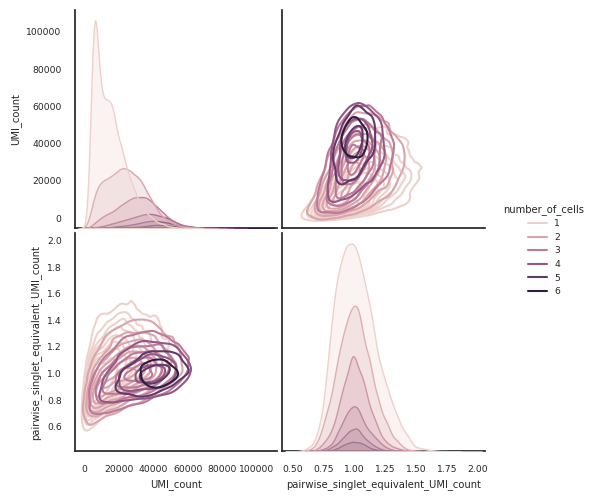

In [49]:
sns.pairplot(full_pop.cells.query('gem_group==1')[['UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'number_of_cells']],
             hue='number_of_cells', kind='kde')

# Normalize capture probabilities

In [50]:
from scipy.stats import trim_mean

def p_normalize(pop, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_number_of_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    normalized = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
        
        p['number_of_cells'] = pop.cells['number_of_cells']
        p.set_index('number_of_cells', append=True, inplace=True)
        
        # observed average probability per transcript by number_of_cells
        if trim: # trimmed mean to reduce dependence on outliers
            P = dict()
            for level, df in p.groupby(level=1):
                P[level] = df.apply(lambda x: trim_mean(x, proportion_to_cut))
            P = pd.DataFrame(P).T
        else:
            P = p.groupby(level=1).mean()
        
        if normalize_to_singlets:
            mu = P.loc[1]
        else:
            if trim:
                mu = p.apply(lambda x: trim_mean(x, proportion_to_cut))
            else:
                mu = p.mean()
        
        # normalize to equal average probability across all droplets to yield scale factors
        Q = P.div(mu)
        
        factors = pd.DataFrame(Q.loc[p.index.get_level_values(1)].values, index=p.index, columns=p.columns)
        
        if normalize_to_constant and scale_by_number_of_cells:
            # normalize singlets to 10k, doublets to 20k, triplets to 30k, etc.
            p = (p/factors).mul(p.index.get_level_values(1)*UMI_constant, axis=0).droplevel(1)
        elif normalize_to_constant and not scale_by_number_of_cells:
            # normalize all to 10k
            p = (p/factors).droplevel(1)*UMI_constant
        else:
            # normalize back by original observed number of UMIs
            p = (p/factors).droplevel(1).mul(UMI_counts.loc[gem_group_cells], axis=0)
            
        normalized[gem] = p
    
    return pd.concat(normalized.values())

In [51]:
p = p_normalize(full_pop, genes='mean > 0.25',
                UMI_constant=1,
                scale_by_number_of_cells=False,
                normalize_to_singlets=False,
                trim=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
full_pop.cells['final_pairwise_UMI_count'] = p.mul(full_pop.cells['pairwise_singlet_equivalent_UMI_count']*10000, axis=0).sum(axis=1)

In [58]:
full_pop.to_hdf('/data/norman/southark/rpe1e150_standardized/20240227_RPE1_E150_all_genes.hdf')

Writing matrix...
Writing metadata...
! Converting categorical columns to string...
! Converting categorical columns to string...
Done in 116.2905056476593s.
